# Imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from typing import List
import torch
from torch import Tensor
import pickle
import wandb
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn, optim
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing

# Load Dataset

In [2]:
def load_and_process_movies(
        ratings_path,
        rating_threshold,
        user_min_interactions=0,
        item_min_interactions=0,
        user_max_interactions=0,
        item_max_interactions=0,
        val_size=0.1,
        test_size=0.1,
        random_state=42):

    # Load ratings
    ratings_df = pd.read_csv(ratings_path)
    print(f"Loaded {len(ratings_df)} ratings")

    # Filter users with minimum interactions
    if user_min_interactions > 0:
        user_counts = ratings_df['userId'].value_counts()
        valid_users = user_counts[user_counts >= user_min_interactions].index
        ratings_df = ratings_df[ratings_df['userId'].isin(valid_users)]
        print(f"Filtered to {len(ratings_df)} ratings from users with at least {user_min_interactions} interactions")

    # Filter items with minimum interactions
    if item_min_interactions > 0:
        item_counts = ratings_df['movieId'].value_counts()
        valid_items = item_counts[item_counts >= item_min_interactions].index
        ratings_df = ratings_df[ratings_df['movieId'].isin(valid_items)]
        print(f"Filtered to {len(ratings_df)} ratings for items with at least {item_min_interactions} interactions")


    if user_max_interactions > 0:
        user_counts = ratings_df['userId'].value_counts()
        valid_users = user_counts[user_counts < user_max_interactions].index
        ratings_df = ratings_df[ratings_df['userId'].isin(valid_users)]
        print(f"Filtered to {len(ratings_df)} ratings from users with at most {user_max_interactions} interactions")

    # Filter items with minimum interactions
    if item_max_interactions > 0:
        item_counts = ratings_df['movieId'].value_counts()
        valid_items = item_counts[item_counts < item_max_interactions].index
        ratings_df = ratings_df[ratings_df['movieId'].isin(valid_items)]
        print(f"Filtered to {len(ratings_df)} ratings for items with at most {item_max_interactions} interactions")

    # Encode user and item IDs
    user_encoder = preprocessing.LabelEncoder()
    item_encoder = preprocessing.LabelEncoder()

    user_encoder.fit(ratings_df['userId'])
    item_encoder.fit(ratings_df['movieId'])

    num_users = len(user_encoder.classes_)
    num_items = len(item_encoder.classes_)
    print(f"Dataset has {num_users} users and {num_items} items")

    # Create mapping dictionaries
    user_id_to_idx = {id_: idx for idx, id_ in enumerate(user_encoder.classes_)}
    item_id_to_idx = {id_: idx for idx, id_ in enumerate(item_encoder.classes_)}
    idx_to_user_id = {idx: id_ for id_, idx in user_id_to_idx.items()}
    idx_to_item_id = {idx: id_ for id_, idx in item_id_to_idx.items()}

    # Encode the dataframe
    ratings_encoded = ratings_df.copy()
    ratings_encoded['user_idx'] = user_encoder.transform(ratings_df['userId'])
    ratings_encoded['item_idx'] = item_encoder.transform(ratings_df['movieId'])

    # Apply rating threshold to create binary interactions
    # Create a copy with interactions above threshold as positive edges
    positive_df = ratings_encoded[ratings_encoded['rating'] >= rating_threshold].copy()

    # Split into train/val/test
    temp_size = val_size + test_size
    train_df, temp_df = train_test_split(positive_df, test_size=temp_size, random_state=random_state)

    val_size_adjusted = val_size / temp_size
    val_df, test_df = train_test_split(temp_df, test_size=(1 - val_size_adjusted), random_state=random_state)

    print(f"Split into {len(train_df)} training, {len(val_df)} validation, and {len(test_df)} testing interactions")

    # Create edge indices for LightGCN
    train_edge_index = torch.LongTensor([
        train_df['user_idx'].values,
        train_df['item_idx'].values
    ])

    val_edge_index = torch.LongTensor([
        val_df['user_idx'].values,
        val_df['item_idx'].values
    ])

    test_edge_index = torch.LongTensor([
        test_df['user_idx'].values,
        test_df['item_idx'].values
    ])


    return {
        'num_users': num_users,
        'num_items': num_items,
        'train_edge_index': train_edge_index,
        'val_edge_index': val_edge_index,
        'test_edge_index': test_edge_index,
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df,
        'user_encoder': user_encoder,
        'item_encoder': item_encoder,
        'user_id_to_idx': user_id_to_idx,
        'item_id_to_idx': item_id_to_idx,
        'idx_to_user_id': idx_to_user_id,
        'idx_to_item_id': idx_to_item_id,
        'ratings_df': ratings_df,
        'ratings_encoded': ratings_encoded
    }

In [3]:
#this is used to convert from interaction matrix edge index to adjacency matrix edge index, necessary for bipartite graphs
def convert_r_mat_to_adj_mat(
        input_edge_index,
        num_users,
        num_items):

    #extract user and book indices from the input edge index
    user_indices = input_edge_index[0]
    book_indices = input_edge_index[1]

    #for the top right block (users to books), book indices need to be shifted by num_users
    edge_index_top_right = torch.stack([user_indices, book_indices + num_users], dim=0)

    #For the bottom left block (books to users), similarly shift book indices.
    edge_index_bottom_left = torch.stack([book_indices + num_users, user_indices], dim=0)

    #concatenate both parts to get the full sparse edge index for the bipartite graph.
    adj_edge_index = torch.cat([edge_index_top_right, edge_index_bottom_left], dim=1)

    return adj_edge_index


In [4]:
#convert from adjacency matrix edge index into rating matrix edge index
def convert_adj_mat_to_r_mat(
        adj_edge_index,
        num_users):
    #the top right block has user-book edges:
    #user nodes have indices < num_users, and book nodes have indices >= num_users.
    mask = (adj_edge_index[0] < num_users) & (adj_edge_index[1] >= num_users)

    #extract the user indices as is.
    user_indices = adj_edge_index[0][mask]

    #for the book indices, subtract num_users to convert back to the original indexing.
    book_indices = adj_edge_index[1][mask] - num_users

    #return the rating matrix edge index.
    return torch.stack([user_indices, book_indices], dim=0)

In [5]:
def prepare_lightgcn_data(
        base_path,
        rating_threshold,
        user_min_interactions=0,
        item_min_interactions=0,
        user_max_interactions=0,
        item_max_interactions=0,
        val_size=0.1,
        test_size=0.1,
        random_state=42):


    #load the movies
    data = load_and_process_movies(
        base_path,
        rating_threshold=rating_threshold,
        user_min_interactions=user_min_interactions,
        item_min_interactions=item_min_interactions,
        user_max_interactions=user_max_interactions,
        item_max_interactions=item_max_interactions,
        val_size=val_size,
        test_size=test_size,
        random_state=random_state
    )


    #convert the train index from interaction form to adj form, this will be fed to the model
    data['train_adj_edge_index'] = convert_r_mat_to_adj_mat(
        data['train_edge_index'], data['num_users'], data['num_items']
    )

    data['val_adj_edge_index'] = convert_r_mat_to_adj_mat(
        data['val_edge_index'], data['num_users'], data['num_items']
    )

    data['test_adj_edge_index'] = convert_r_mat_to_adj_mat(
        data['test_edge_index'], data['num_users'], data['num_items']
    )


    return data

# LightGCN

## Model

In [6]:
# defines LightGCN model.py
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(
            self,
            num_users,
            num_items,
            embedding_dim=64,
            num_layers=3,
            add_self_loops=False):

        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = num_layers
        self.add_self_loops = add_self_loops

        # define user and item embedding for direct look up.
        # embedding dimension: num_user/num_item x embedding_dim
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)

        #initialized according to LightGCN paper
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(
            self,
            edge_index: Tensor):

        #get the normalization that needs to be applied to the messages
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)



        # create the embedding matrix at layer 0
        # size will be (n_users + n_items) x emb_vector_len
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])

        embs = [emb_0]

        # emb_k is the emb that we are actually going to push it through the graph layers
        emb_k = emb_0

        # push the embeddings through the model K times
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)



        embs = torch.stack(embs, dim=1)

        #final embs are a simple mean of embs from all layers, according to the paper, it has decent performance
        emb_final = torch.mean(embs, dim=1)


        #split the matrix into user final embs and item final embs
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

## Loss Fun

In [7]:
def bpr_loss(users_emb_final, 
             users_emb_0, 
             pos_items_emb_final, 
             pos_items_emb_0, 
             neg_items_emb_final, 
             neg_items_emb_0, 
             lambda_val):
    
    # calculate prediction scores
    pos_scores = (users_emb_final * pos_items_emb_final).sum(1)
    neg_scores = (users_emb_final * neg_items_emb_final).sum(1)
    
    # calculate mf loss
    mf_loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    
    # regularization using batch normalization

    #get batch size
    batch_size = float(users_emb_0.size(0))

    #calculate using batch normalization
    reg_loss = lambda_val * (1/2) * (
        users_emb_0.norm(2).pow(2) + 
        pos_items_emb_0.norm(2).pow(2) + 
        neg_items_emb_0.norm(2).pow(2)
    ) / batch_size
    
    return mf_loss + reg_loss

## Sampling

In [8]:
def random_negative_sampling(
    edge_index,
    num_users,
    num_items,
    batch_size
) :

    if not isinstance(edge_index, torch.Tensor):
        edge_index = torch.tensor(edge_index)

    # Ensure edge_index has the right shape
    if edge_index.shape[0] != 2:
        raise ValueError("Edge index should have shape [2, num_edges]")

    # Create a dictionary of user interactions for faster negative sampling
    user_interactions = {}
    for u, i in zip(edge_index[0].tolist(), edge_index[1].tolist()):
        if u not in user_interactions:
            user_interactions[u] = set()
        user_interactions[u].add(i)

    # sample positive interactions
    num_edges = edge_index.shape[1]
    pos_indices = torch.randint(0, num_edges, (batch_size,))

    # get the user that made the interaction
    user_ids = edge_index[0][pos_indices]

    #get the items that were interacted with
    pos_item_ids = edge_index[1][pos_indices]

    neg_item_ids = torch.zeros_like(user_ids)

    #sample negative item ids from the set of items that the user has not interacted with
    for i, user_id in enumerate(user_ids):
        user_id = user_id.item()

        #get set of items user interacted with
        interacted_items = user_interactions.get(user_id, set())

        #randomly select a random item, if the user interacted with this item, sample again.
        while True:
            neg_item = torch.randint(0, num_items, (1,)).item()
            if neg_item not in interacted_items:
                neg_item_ids[i] = neg_item
                break

    return user_ids, pos_item_ids, neg_item_ids

## Evaluation Metrics

In [9]:
def get_user_positive_items(edge_index):
    user_pos_items = {}
    
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        
        if user not in user_pos_items:
            user_pos_items[user] = []
        
        user_pos_items[user].append(item)
        
    return user_pos_items

In [10]:
# computes recall@K and precision@K
def RecallPrecision_ATk(
        groundTruth,
        r,
        k):

    
    # number of correctly predicted items per user
    num_correct_pred = torch.sum(r, dim=-1)  
    
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [11]:
# computes NDCG@K
def NDCGatK_r(
        groundTruth,
        r,
        k):


    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1


    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [12]:
def get_metrics(model,
                input_edge_index,
                num_users,
                train_edge_index,
                input_exclude_edge_indices,
                k):


    users_emb_final, _, items_emb_fused, _ = model(train_edge_index)
    user_embedding = users_emb_final  # final learned user embeddings
    item_embedding = items_emb_fused  # final fused item embeddings

    # convert to interaction matrix form
    edge_index = convert_adj_mat_to_r_mat(input_edge_index, num_users)
    exclude_edge_indices = [convert_adj_mat_to_r_mat(exclude_edge_index, num_users)
                           for exclude_edge_index in input_exclude_edge_indices]

    # get unique users
    users = edge_index[0].unique()

    # get user's positive items
    test_user_pos_items = get_user_positive_items(edge_index)

    exclude_items_dict = {}
    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_positive_items(exclude_edge_index)
        for user, items in user_pos_items.items():
            if user not in exclude_items_dict:
                exclude_items_dict[user] = set(items)
            else:
                exclude_items_dict[user].update(items)

    # prepare test user positive items list for metric calculation
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # initialize results container
    all_user_results = []

    # process users in batches to save memory
    batch_size = 128
    num_items = item_embedding.shape[0]

    for i in range(0, len(users), batch_size):
        batch_users = users[i:i+batch_size]
        batch_results = []

        for user in batch_users:
            user_id = user.item()
            # compute ratings for this user only
            user_emb = user_embedding[user_id].unsqueeze(0)  # Shape: 1 x embed_dim
            user_ratings = torch.matmul(user_emb, item_embedding.T).squeeze(0)  # Shape: num_items

            # apply exclusion mask for this user
            if user_id in exclude_items_dict:
                exclusion_mask = torch.zeros(num_items, dtype=torch.bool, device=user_ratings.device)
                exclude_indices = list(exclude_items_dict[user_id])
                if exclude_indices:  # check if the list is not empty
                    exclusion_mask[exclude_indices] = True
                    user_ratings = user_ratings.clone()
                    user_ratings[exclusion_mask] = -(1 << 10)

            # get top-k items for this user
            _, user_top_k = torch.topk(user_ratings, k=k)

            # check which top-k items are relevant
            user_true_relevant = test_user_pos_items[user_id]
            label = [item.item() in user_true_relevant for item in user_top_k]
            batch_results.append(label)

        all_user_results.extend(batch_results)

    # convert to tensor for metric calculation
    r = torch.Tensor(np.array(all_user_results).astype('float'))

    # calculate metrics
    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [13]:
# wrapper function to evaluate model.py
def evaluation(model,
               num_users,
               edge_index, # adj_mat based edge index
               train_edge_index,
               exclude_edge_indices: List,  # adj_mat based exclude edge index
               k,
               lambda_val
              ):


    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)

    r_mat_edge_index = convert_adj_mat_to_r_mat(edge_index, num_users)

    # get the set of all items that appear in the edge_index
    all_items = torch.unique(r_mat_edge_index[1]).tolist()

    # create a dictionary to track user interactions for negative sampling
    user_interactions = {}
    for u, i in zip(r_mat_edge_index[0].tolist(), r_mat_edge_index[1].tolist()):
        if u not in user_interactions:
            user_interactions[u] = set()
        user_interactions[u].add(i)

    # use all positive edges
    user_indices = r_mat_edge_index[0]
    pos_item_indices = r_mat_edge_index[1]

    # generate negative item indices with the same shape as pos_item_indices
    neg_item_indices = torch.zeros_like(pos_item_indices)

    for idx, user_id in enumerate(user_indices):
        user_id = user_id.item()
        interacted_items = user_interactions.get(user_id, set())

        # find items this user hasn't interacted with
        available_neg_items = [item for item in all_items if item not in interacted_items]

        if available_neg_items:

            # randomly select one negative item
            neg_item = random.choice(available_neg_items)
            neg_item_indices[idx] = neg_item
        else:
            # if all items have been interacted with by this user (rare case),
            # just pick a random item as negative
            neg_item = random.choice(all_items)
            neg_item_indices[idx] = neg_item

    # get embeddings for all users and items
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]


    #calculate the loss

    loss = bpr_loss(users_emb_final,
                    users_emb_0,
                    pos_items_emb_final,
                    pos_items_emb_0,
                    neg_items_emb_final,
                    neg_items_emb_0,
                    lambda_val).item()

    #calculate the metrics
    recall, precision, ndcg = get_metrics(model,
                                          edge_index,
                                          num_users,
                                          train_edge_index,
                                          exclude_edge_indices,
                                          k)

    return loss, recall, precision, ndcg

## Training 

In [14]:
def get_embs_for_bpr(model, input_edge_index, num_users, num_items, batch_size, device):

    #get the initial and final user/item embs from the model
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)


    #convert to interaction form
    edge_index_to_use = convert_adj_mat_to_r_mat(input_edge_index, num_users)



    # mini batching for eval and loss calculation
    user_indices, pos_item_indices, neg_item_indices = random_negative_sampling(edge_index_to_use, num_users, num_items,batch_size)

    #move indices to device
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    
 
    # we need layer0 embeddings and the final embeddings (computed from 0...K layer) for BPR loss
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
   
    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

In [15]:
def train_lightgcn(
        model,
        optimizer,
        scheduler,
        data,
        config,
        use_wandb=True):

    iterations = config.get('iterations', 5000)
    num_layers = config.get('num_layers', 3)
    batch_size = config.get('batch_size', 2048)
    lambda_val = config.get('lambda_val', 1e-6)
    eval_every = config.get('eval_every', 200)
    lr_decay_every = config.get('lr_decay_every', 200)
    k = config.get('k', 20)

    device = next(model.parameters()).device



    train_adj_edge_index = data['train_adj_edge_index'].to(device)

    val_adj_edge_index = data['val_adj_edge_index'].to(device)


    history = {
        'iterations': [],
        'train_loss': [],
        'val_loss': [],
        'val_recall': [],
        'val_precision': [],
        'val_ndcg': []
    }


    patience = config.get('patience', 10)
    min_delta = config.get('min_delta', 0.001)

    best_ndcg = 0
    patience_counter = 0


    model.train()


    for iteration in tqdm(range(iterations)):

        # forward propagation  
        users_emb_final, users_emb_0,  pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
                    = get_embs_for_bpr(model, train_adj_edge_index, data['num_users'], data['num_items'], batch_size, device)
        
        
        # loss computation
        train_loss = bpr_loss(users_emb_final, users_emb_0, 
                              pos_items_emb_final, pos_items_emb_0, 
                              neg_items_emb_final, neg_items_emb_0, 
                              lambda_val)

        #grad descent
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        #log the train_loss
        wandb.log({
            "train_loss": train_loss.item(),
            "iteration": iteration
        })
    
        # validation set
        if iteration % eval_every == 0:
            model.eval()
            
            with torch.no_grad():

                #evaluate of val set, exclude the train adj edge index from the metrics eval
                val_loss, val_recall, val_precision, val_ndcg = evaluation(
                    model=model,
                    num_users = data['num_users'],
                    edge_index = val_adj_edge_index,
                    train_edge_index = train_adj_edge_index,
                    exclude_edge_indices=[train_adj_edge_index],
                    k=k,
                    lambda_val=lambda_val
                )

                # Early stopping check
                if val_ndcg > best_ndcg + min_delta:
                    best_ndcg = val_ndcg
                    patience_counter = 0
                    # Save best model
                    torch.save(model.state_dict(), 'best_lightgcn_model.pt')
                else:
                    patience_counter += 1
                
    
                print(f"[Iteration {iteration}/{iterations}] "
                      f"train_loss: {train_loss.item():.5f}, val_loss: {val_loss:.5f}, "
                      f"val_recall@{k}: {val_recall:.5f}, val_precision@{k}: {val_precision:.5f}, "
                      f"val_ndcg@{k}: {val_ndcg:.5f}")


                #log to history
                history['iterations'].append(iteration)
                history['train_loss'].append(train_loss.item())
                history['val_loss'].append(val_loss)
                history['val_recall'].append(val_recall)
                history['val_precision'].append(val_precision)
                history['val_ndcg'].append(val_ndcg)
    
                #log to wandb
                if use_wandb:
                    wandb.log({
                        "val_loss": val_loss,
                        "val_recall@k": val_recall,
                        "val_precision@k": val_precision,
                        "val_ndcg@k": val_ndcg,
                        "evaluation_iteration": iteration
                    })

                # Early stopping trigger
                if patience_counter >= patience:
                    print(f"Early stopping triggered at iteration {iteration}")
                    break

            model.train()

        #decay learning rate every lr_decay_every iterations
        if scheduler is not None and iteration % lr_decay_every == 0 and iteration > 0:
            scheduler.step()

    return history
    

## Evaluation

In [16]:
def test_model(
        model,
        data,
        config):

    print("Evaluating on test set...")

    #extract parameters
    k = config.get('k', 20)
    lambda_val = config.get('lambda_val', 1e-6)

    #get model device
    device = next(model.parameters()).device

    #move to device
    train_adj_edge_index = data['train_adj_edge_index'].to(device)
    val_adj_edge_index = data['val_adj_edge_index'].to(device)
    test_adj_edge_index = data['test_adj_edge_index'].to(device)

    # eval
    model.eval()

    with torch.no_grad():
        #evaluate on val test
        test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model,
            data['num_users'],
            test_adj_edge_index,
            train_adj_edge_index,
            [train_adj_edge_index, val_adj_edge_index],
            k,
            lambda_val
        )

    #print results
    print(f"Test Results:")
    print(f"Loss: {test_loss:.5f}")
    print(f"Recall@{k}: {test_recall:.5f}")
    print(f"Precision@{k}: {test_precision:.5f}")
    print(f"NDCG@{k}: {test_ndcg:.5f}")

    #return the metrics
    return {
        'loss': test_loss,
        f'recall@{k}': test_recall,
        f'precision@{k}': test_precision,
        f'ndcg@{k}': test_ndcg
    }

In [17]:
def plot_training_history(history):

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['iterations'], history['train_loss'], label='Train Loss')
    ax1.plot(history['iterations'], history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot metrics
    ax2.plot(history['iterations'], history['val_recall'], label='Recall@k')
    ax2.plot(history['iterations'], history['val_precision'], label='Precision@k')
    ax2.plot(history['iterations'], history['val_ndcg'], label='NDCG@k')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Validation Metrics')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    fig.tight_layout()
    plt.show()

In [18]:

#set seed to ensure consistency
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def run_lightgcn_experiment(data_path, experiment_name=None, config=None, save_model=True, use_wandb=True):

    #set seed to ensure consistency
    set_seed(42)
    
    # default config
    default_config = {
        'embedding_dim': 64,
        'n_layers': 3,
        'add_self_loops': False,
        'lambda_val': 1e-6,
        'lr': 1e-3,
        'batch_size': 1024,
        'iterations': 10000,
        'eval_every': 200,
        'lr_decay_every': 200,
        'lr_decay_factor': 0.95,
        'k': 20,
        'user_min_interactions': 0,
        'item_min_interactions': 0,
        'val_size': 0.2,
        'rating_threshold':3.5
    }
    
    # if provided update config
    if config is not None:
        default_config.update(config)
    
    config = default_config
    
    # generate experiment name
    if experiment_name is None:
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        experiment_name = f"lightgcn-no-lr-decay-{timestamp}"
    
    print(f"Starting experiment: {experiment_name}")
    print(f"Configuration: {config}")
    
    # init wandb
    if use_wandb:
        wandb.init(
            project="lightgcn-recommendations",
            name=experiment_name,
            config=config,
            mode="offline"
        )
    
    # load data
    print("Loading and preparing data...")
    data = prepare_lightgcn_data(
        data_path,
        rating_threshold=config['rating_threshold'],
        user_min_interactions=config['user_min_interactions'],
        item_min_interactions=config['item_min_interactions'],
        user_max_interactions=config['user_max_interactions'],
        item_max_interactions=config['item_max_interactions'],
        val_size=config['val_size'],
        test_size = config['test_size'],
        random_state=42
    )

    print("Initializing model...")

    # device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = LightGCN(
        num_users=data['num_users'],
        num_items=data['num_items'],
        embedding_dim=config['embedding_dim'],
        num_layers=config['n_layers'],
        add_self_loops=config['add_self_loops']
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['lr_decay_factor'])



    print("Training model...")
    start_time = time.time()
    
    history = train_lightgcn(
        model=model,
        optimizer=optimizer,
        scheduler=None,
        data=data,
        config=config,
        use_wandb=use_wandb
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    #final eval
    test_results = test_model(model, data, config)
    
    #plot history
    plot_training_history(history)
    
    #save model and data
    if save_model:

        save_dir = f"saved_models/{experiment_name}"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), f"{save_dir}/model.pt")

        with open(f"{save_dir}/lightgcn_data.pkl", 'wb') as f:
            pickle.dump({
                'user_mapping': list(data['idx_to_user_id'].values()),
                'item_mapping': list(data['idx_to_item_id'].values()),
                'edge_index': data['train_adj_edge_index'].cpu(),
                'config': config
            }, f)

        #save history
        history_df = pd.DataFrame(history)
        history_df.to_csv(f"{save_dir}/history.csv", index=False)
        
        print(f"Model and results saved to {save_dir}")
    
    #close wandb
    if use_wandb:
        wandb.finish()
    
    return {
        'model': model,
        'history': history,
        'test_results': test_results,
        'config': config,
        'data': data
    }

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Starting experiment: lightgcn-no-lr-decay-20250505-101743
Configuration: {'embedding_dim': 64, 'n_layers': 2, 'add_self_loops': False, 'lambda_val': 0.0001, 'lr': 0.0001, 'batch_size': 256, 'iterations': 30000, 'eval_every': 200, 'lr_decay_every': 200, 'lr_decay_factor': 0.95, 'k': 20, 'user_min_interactions': 0, 'item_min_interactions': 0, 'val_size': 0.1, 'rating_threshold': 3.5, 'implicit_feedback': True, 'user_max_interactions': 0, 'item_max_interactions': 30, 'test_size': 0.2}


wandb: Tracking run with wandb version 0.19.6
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Loading and preparing data...
Loaded 997313 ratings
Filtered to 9548 ratings for items with at most 30 interactions
Dataset has 2466 users and 833 items
Split into 2701 training, 386 validation, and 773 testing interactions
Initializing model...
Using device: cuda
Training model...


/tmp/ipykernel_26/2970459162.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_edge_index = torch.LongTensor([


  0%|          | 0/30000 [00:00<?, ?it/s]

[Iteration 0/30000] train_loss: 0.66158, val_loss: 0.59864, val_recall@20: 0.02724, val_precision@20: 0.00144, val_ndcg@20: 0.00805
[Iteration 200/30000] train_loss: 0.65230, val_loss: 0.59498, val_recall@20: 0.03045, val_precision@20: 0.00160, val_ndcg@20: 0.00924
[Iteration 400/30000] train_loss: 0.63946, val_loss: 0.59017, val_recall@20: 0.04113, val_precision@20: 0.00224, val_ndcg@20: 0.01210
[Iteration 600/30000] train_loss: 0.62195, val_loss: 0.58219, val_recall@20: 0.04220, val_precision@20: 0.00240, val_ndcg@20: 0.01346
[Iteration 800/30000] train_loss: 0.60602, val_loss: 0.57433, val_recall@20: 0.05182, val_precision@20: 0.00288, val_ndcg@20: 0.01779
[Iteration 1000/30000] train_loss: 0.57893, val_loss: 0.56294, val_recall@20: 0.06490, val_precision@20: 0.00385, val_ndcg@20: 0.02178
[Iteration 1200/30000] train_loss: 0.54974, val_loss: 0.55281, val_recall@20: 0.07826, val_precision@20: 0.00481, val_ndcg@20: 0.02593
[Iteration 1400/30000] train_loss: 0.51342, val_loss: 0.53706,

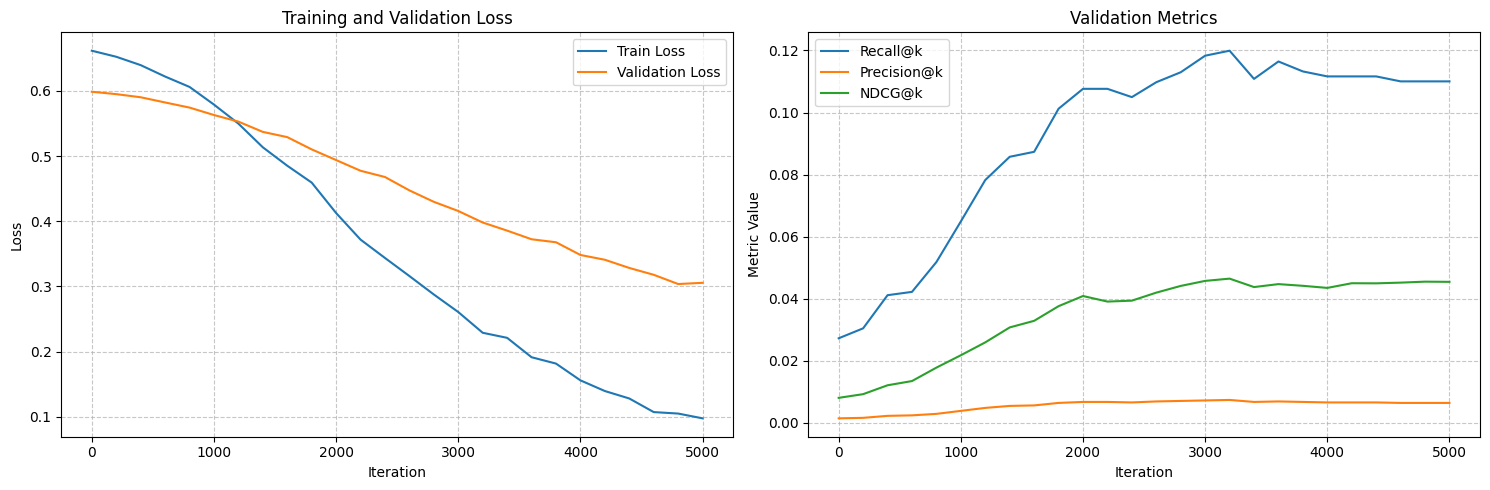

wandb:                                                                                


Model and results saved to saved_models/lightgcn-no-lr-decay-20250505-101743


wandb: 
wandb: Run history:
wandb: evaluation_iteration ▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
wandb:            iteration ▁▁▁▁▁▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
wandb:           train_loss █████▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb:             val_loss ████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁
wandb:           val_ndcg@k ▁▁▂▂▃▄▄▅▆▆▇▇▇▇██████▇█████
wandb:      val_precision@k ▁▁▂▂▃▄▅▆▆▇▇▇▇▇███▇▇▇▇▇▇▇▇▇
wandb:         val_recall@k ▁▁▂▂▃▄▅▅▆▇▇▇▇▇▇██▇█▇▇▇▇▇▇▇
wandb: 
wandb: Run summary:
wandb: evaluation_iteration 5000
wandb:            iteration 5000
wandb:           train_loss 0.09767
wandb:             val_loss 0.30556
wandb:           val_ndcg@k 0.04544
wandb:      val_precision@k 0.00641
wandb:         val_recall@k 0.11004
wandb: 
wandb: You can sync this run to the cloud by running:
wandb: wandb sync /kaggle/working/wandb/offline-run-20250505_101743-mj3rq4p6
wandb: Find logs at: ./wandb/offline-run-20250505_101743-mj3rq4p6/logs


{'model': LightGCN(),
 'history': {'iterations': [0,
   200,
   400,
   600,
   800,
   1000,
   1200,
   1400,
   1600,
   1800,
   2000,
   2200,
   2400,
   2600,
   2800,
   3000,
   3200,
   3400,
   3600,
   3800,
   4000,
   4200,
   4400,
   4600,
   4800,
   5000],
  'train_loss': [0.6615768074989319,
   0.6522958278656006,
   0.6394648551940918,
   0.6219473481178284,
   0.6060187220573425,
   0.5789307951927185,
   0.549744188785553,
   0.513418972492218,
   0.48516225814819336,
   0.4592803716659546,
   0.412591814994812,
   0.3718186318874359,
   0.34365177154541016,
   0.31591466069221497,
   0.2876235544681549,
   0.26070937514305115,
   0.22892053425312042,
   0.22114123404026031,
   0.19139379262924194,
   0.18166007101535797,
   0.15592680871486664,
   0.1395476907491684,
   0.12811774015426636,
   0.10725296288728714,
   0.10500441491603851,
   0.09766866266727448],
  'val_loss': [0.5986388921737671,
   0.5949789881706238,
   0.5901734232902527,
   0.5821940302848816

In [19]:


 config = {
        'embedding_dim': 64,
        'n_layers': 2,
        'add_self_loops': False,
        'lambda_val': 0.0001 ,
        'lr': 0.0001,
        'batch_size': 256,
        'iterations': 30000,
        'eval_every': 200,
        'lr_decay_every': 200,
        'lr_decay_factor': 0.95,
        'k': 20,
        'implicit_feedback': True,
        'user_min_interactions': 0,
        'item_min_interactions': 0,
        'user_max_interactions': 0,
        'item_max_interactions': 30,
        'val_size': 0.1,
        'test_size' : 0.2,
        'rating_threshold': 3.5
    }


run_lightgcn_experiment(data_path = '/kaggle/input/data-preprocessing-and-embedding-generation/ratings.csv', config=config)


In [20]:
#  config = {
#         'embedding_dim': 64,
#         'n_layers': 2,
#         'add_self_loops': False,
#         'lambda_val': 1e-6,
#         'lr': 1e-3,
#         'batch_size': 1024,
#         'iterations': 10000,
#         'eval_every': 200,
#         'lr_decay_every': 200,
#         'lr_decay_factor': 0.95,
#         'k': 20,
#         'user_min_interactions': 0,
#         'item_min_interactions': 0,
#         'val_size': 0.2,

#         'rating_threshold': 3.5
#  }

# run_lightgcn_experiment(data_path = '/kaggle/input/data-preprocessing-and-embedding-generation/ratings.csv',experiment_name="latest", config=config)